# IDEAS

### Inspiring Kernels
* https://www.kaggle.com/harvinderwazir/match-outcome-prediction-in-football

* https://www.kaggle.com/stvrdo/goals-ratings-simulations/notebook

* https://www.kaggle.com/petehodge/epl-weekly-predicting/notebook
    
### VISUALIZATIONS - MUY IMPORTANTE
[Seventeen Ways to Map Data in Kaggle kernels](http://blog.kaggle.com/2016/11/30/seventeen-ways-to-map-data-in-kaggle-kernels/) 


## Background


# TYPE FROM PROPOSAL


# Data Preprocessing

### Type of data

The dataset is available at https://www.kaggle.com/hugomathien/soccer/data. The data is in the form of a sqlite database. 

### About the data

The data contains the following tables:

*** Country, League, Match, Player, Player_Attributes, Team, Team_Attributes***

The tables *country, league, player and team* are lookup tables. Lets focus on the table with attributes - Player_Attributes, Team_Attributes and Match.
In the following code cell, I read the SQLITE table and display the first record of all these three tables.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
import data_preprocess as dp
# Import supplementary visualization code visuals.py, renamed as visuals_udacity.py. I have taken this code from the Udacity
# machine learning projects
from Utils import *

# Pretty display for notebooks
%matplotlib inline
conn = dp.uncompress_and_open_sqlite()
print ("Players")
players_df = dp.sql_to_dataframe(conn, select_all_query_table("Player_Attributes"))
display(players_df.head(n=1))
print ("Teams")
teams_df = dp.sql_to_dataframe(conn, select_all_query_table("Team_Attributes"))
display(teams_df.head(n=1))
print ("Matches")
match_df = dp.sql_to_dataframe(conn, select_all_query_table("Match"))
display(match_df.head(n=1))

Players


,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0


Teams


,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover


Matches


,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.0,1.65,3.4,4.5,1.78,3.25,4.0,1.73,3.4,4.2


### Defining the data features and labels
# TODO: Put a small description of the features here.
* Players

The output label is the 'overall_rating' column; the features are the rest of columns (minus the metadata columns). Note that we might drop some features in subsequent sections, but lets keep them all for now. We will be using the output label for assessing a team's rating based on individual players' ratings.

In [2]:
players_skills = players_df[['player_api_id', 'finishing', 'sliding_tackle', 'gk_reflexes', 'short_passing', 'date']]
players_ratings_label = players_df[['player_api_id','date', 'overall_rating']]
players_features_df = players_df.drop(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating', 'potential'], axis=1)
display(players_features_df.head(n=1))

,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0


* Teams
No output label. I'll drop the metadata to get features.

In [3]:
teams_features_df = teams_df.drop(['id', 'team_fifa_api_id', 'team_api_id', 'date'], axis=1)
display(teams_features_df.head(n=1))

,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,60,Balanced,NaN,Little,50,Mixed,Organised,60,Normal,65,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover


* Clustering matches based on excitement - This is an unsupervised learning problem, and excitement is kind of hard to describe. I will consider excitement in terms of the number of goals, red cards, incidents etc. See later section for implementation.


### Generating output labels

The matches have the goals score information (by home and away) teams; however don't have a label. I am generating a label, based on the goals scored.

#### Get match results
In the following code cell, I apply a lambda function to get the result label as either ['Home Win', 'Away Win', 'Draw']. Then, following what was done in *Charity ML*, I one hot-encode the result label into a vector. Five samples of each of the two steps is shown.

#### Get bookkepper odds

In [4]:
import matches as matches
reload(matches)
match_df['result_label'] = match_df.apply(matches.result, axis = 1)
display(match_df[['home_team_goal', 'away_team_goal', 'result_label']].sample(n=5))

one_hot_match_result_labels = pd.get_dummies(match_df['result_label'])
display(one_hot_match_result_labels.sample(n=5))

,home_team_goal,away_team_goal,result_label
2804,2,3,AWAY_WIN
25542,4,1,HOME_WIN
1003,3,3,DRAW
14898,1,0,HOME_WIN
25072,1,4,AWAY_WIN


,AWAY_WIN,DRAW,HOME_WIN
20638,0,0,1
15433,0,0,1
738,0,0,1
25006,0,0,1
9350,0,0,1


### Defining the base case: The home advantage
Home advantage is real, as mentioned in the Kaggle link, as well as here: http://bleacherreport.com/articles/1604854-how-much-does-home-field-advantage-matter-in-soccer. Lets analyze the home advantage across different leagues.

# DRAW VISUALIZATIONS TO SEE SOME DATA

# See this kernel on how to get match results, betting odds etc : https://www.kaggle.com/harvinderwazir/match-outcome-prediction-in-football/notebook
# https://www.kaggle.com/petehodge/epl-weekly-predicting



In [5]:
# TODO: Finish this function
#home_advantage_per_country = home_advantage(match_df)

Ref for visualizing data
# https://www.kaggle.com/stvrdo/goals-ratings-simulations/notebook

#### Visualizing player ratings
A histogram visualization to view player distributions in terms of ratings will be helpful. I will be using this to gain intution for features such as 'players_in_top_X_percent'. Sometimes a single ***star player*** can win a match for their team; and that is my intuition behind these features.

(63.5, 69.6]      0.323131
(69.6, 75.7]      0.293954
(57.4, 63.5]      0.160802
(75.7, 81.8]      0.128961
(51.3, 57.4]      0.046256
(81.8, 87.9]      0.027373
(45.2, 51.3]      0.011257
(87.9, 94.0]      0.001908
(39.1, 45.2]      0.001636
(32.938, 39.1]    0.000179
Name: overall_rating, dtype: float64

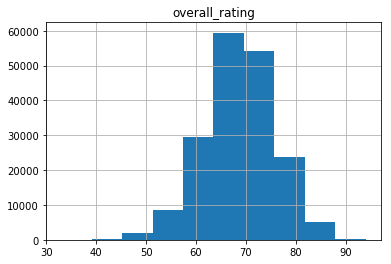

In [6]:
import matplotlib.pyplot as plt
# Visualize player ratings
players_df.hist(column= 'overall_rating', bins = 10)
players_df['overall_rating'].value_counts(bins = 10, normalize=True)

#### Defining the problems

* The holy grail is predicting the outcome of a football match, as mentioned in the kaggle link for the dataset I intend to use 

* Cluster matches based on the excitement level and interest in the game; possibly use this to model ticket prices. I would guess that a match between Real Madrid and Barcelona would be the most expensive. What factors make fans pay more for a match? If I follow a certain team, how much money can I expect to shell out?

* Model players and teams; and assign them a quantifiable number that serves as a rating of skill. I would like to find the answer to the pull of star power; many people tune in to football matches to watch Messi, Neymar or Ronaldo. Note that the capability of players also affects the excitement surrounding football matches.

* The main service they provided is advice to teams on whether or not a player should be bought or sold, not sure if this would be of any help, one of they key concepts they discussed was coming up with a metric on players on how much of an impact the player makes which was calculated by figuring out a team's performance with and without that particular player while taking into account other players and different circumstances.
**Background**
Players get injured all the time, with managers complaning about injuries (insert link). Through this part of the code, I wish to answer this queation: ***How does the team fare if player X is out due to injury for T% of the season?***. For eg. : How does Barcelona do in season 2011-12, had Messi not been there?

### Handling Bad Data

The Kaggle page does say that some input values are missing, and indeed it does. In this code block, I wish to eliminate some of the data where features I think are relevant (more discussion on this in the section on Feature generation). The columns are defined in the Utils.py file in the code. For now, I will be focusing on the match dataframe.

For this I use the *dropna* method in pandas. I certainly do not want to blindly check for validity of all columns in the match; a lot of it is information I don't think is necessary for prediction (bettting data, corners for example); atleast for the problem of determining match results.

Therefore I define the columns IMPORTANT to me, in the aptly named variable.
Luckily, even if I drop the data if ***any*** of the player ratings is absent, I do not lose a lot of data; as shown in the example below.

### TODO: Different processing for the match excitement clustering problem

In [7]:
import Utils as Utils
reload(Utils)
IMPORTANT_COLUMNS = Utils.AWAY_PLAYER_COLUMNS + Utils.HOME_PLAYER_COLUMNS
print ("Number of samples before removing cases of no data: " + str(match_df.shape[0]))
match_clean_data_df = match_df.dropna(axis = 0, how = 'any', subset = IMPORTANT_COLUMNS)
print ("Number of samples after removing cases of no data: " + str(match_clean_data_df.shape[0]))

Number of samples before removing cases of no data: 25979
Number of samples after removing cases of no data: 21374


# Feature Selection

In this section, I generate some features from the given match data, that I think are relevant from my domain knowledge of football.

## TODO: WRITE ABOUT HOW YOU LEARNT ABOUT LAMBDA AND PARTIAL HERE.

### Utility APIs for features
The following code blocks demonstrates the use of some util methods I have in my code, to help get some features from the raw data for the task of match prediction. 

#### Acknowledgement: Thanks to the author of https://www.kaggle.com/harvinderwazir/match-outcome-prediction-in-football/notebook ; for neatly putting up the relevant column names for a particular task! :)

#### Classify a player into midfield, attack and defense
Takes in as an input the relevant player skills and classifies into midfielder, attacker, defender or goalkeeper; based on the most recent numbers from the database. Here I validate my method against the famous players (3 of each of the 4 types) who I know i can classify into the aforementioned categories.
As can be seem from the results (and if you know your football :), my method takes a good decision from the columns of interest. The reason I wish to make this distinction is to better divide a team's rating based on players into defense, attack and midfield; rather than an overall average rating. I will be using this more further in the section on Features and Classification.

In [ ]:
import players as players
reload(players)
player_names_df = dp.sql_to_dataframe(conn, select_all_query_table("Player"))
FAMOUS_PLAYER_NAMES = ['Lionel Messi', 'Cristiano Ronaldo', 'Didier Drogba', 'John Terry', 
                'Rio Ferdinand', 'Gerard Pique', 'Petr Cech', 'Iker Casillas', 
                'Joe Hart', 'Frank Lampard', 'Xavi Hernandez', 'Andres Iniesta']
COLUMNS_OF_INTEREST = ['player_name', 'finishing', 'sliding_tackle',
                     'gk_reflexes', 'short_passing']
for player in FAMOUS_PLAYER_NAMES:
    display(players.player_to_player_type(players_skills=players_skills, player_names_df=player_names_df, 
                                      player_name=player, COLUMNS_OF_INTEREST=COLUMNS_OF_INTEREST))

players.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  latest_skills_df['player_type'] = latest_skills_df.idxmax(axis=1)
players.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  latest_skills_df['player_name'] = player_name
players.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  latest_skills_df['player

,player_name,player_type,player_api_id
102482,Lionel Messi,Attacker,30981


,player_name,player_type,player_api_id
33330,Cristiano Ronaldo,Attacker,30893


,player_name,player_type,player_api_id
43418,Didier Drogba,Attacker,30822


,player_name,player_type,player_api_id
84848,John Terry,Defender,30627


,player_name,player_type,player_api_id
149835,Rio Ferdinand,Defender,30620


,player_name,player_type,player_api_id
62977,Gerard Pique,Defender,37482


,player_name,player_type,player_api_id
142868,Petr Cech,Goalkeeper,30859


,player_name,player_type,player_api_id
72590,Iker Casillas,Goalkeeper,30657


,player_name,player_type,player_api_id
83352,Joe Hart,Goalkeeper,31432


,player_name,player_type,player_api_id
59244,Frank Lampard,Midfielder,30631


,player_name,player_type,player_api_id
180709,Xavi Hernandez,Midfielder,39854


,player_name,player_type,player_api_id
12773,Andres Iniesta,Midfielder,30955


#### Get Average Player Ratings For Match
Takes as an input a match, and returns back the ratings in the form of [midfielder_rating, attacker_rating, defender_rating, goalie_rating] for both the teams. Note that the ratings are based on the first ratings back in time I can find from that season; this is because every player has multiple ratings spread across time. For eg. for 2012-13, I will look for the date closest to Dec 31 2012 and take the player's ratings for that date.

Sometimes, I observed a team has no attacking players (rare, but not impossible); a team might decide to just play defenders and midfielders. In that case, I assign the attacking rating as 0.

#### Team rating without player
Removes a particular player under consideration, and then randomly chooses any of the other 10 to replace him. Across a season or some amount of matches, this is to mimic how a team performs if a particular player is out injured for the season, or his impact on the team if he were to leave the team.

Demonstrating the use of both APIs in the code cell below.

In [ ]:
import matches as matches
reload(matches)
import players as players
reload(players)
from functools import partial
import Utils as Utils
reload(Utils)

# TODO: Move SKILL COLUMNS to Utils.py
SKILL_COLUMNS = ['finishing', 'sliding_tackle',
                     'gk_reflexes', 'short_passing']

player_types= Utils.PLAYER_TYPES
team_types=['away', 'home']
FEATURE_COLUMNS = []
for player_type_input in player_types:
    for team_type in team_types:
        FEATURE = team_type + "_" + player_type_input + "_rating"
        FEATURE_COLUMNS.append(FEATURE)
        get_feature = partial(matches.single_match_rating,players_ratings_label=players_ratings_label, 
                             SKILL_COLUMNS=SKILL_COLUMNS, players_skills=players_skills, 
                              player_type_input=player_type_input, team_type=team_type)
        match_clean_data_df[FEATURE] = match_clean_data_df.apply(get_feature, axis = 1)
display(match_clean_data_df[FEATURE_COLUMNS].head(n=10))


players.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  latest_skills_df['player_type'] = latest_skills_df.idxmax(axis=1)
/Users/sa.goyal/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


# IMPORTANT FEATURES TO DO:
- TEAM FORM GUIDE - last 5 matches, last 10 matches PER SEASON; DEINFE IT AS A STRING; and ENCODE TO CATEGORIAL VALUE
- HOME TEAM HOME RECORD
- AWAY TEAM AWAY RECORD
- AWAY TEAM AWAY RECORD AT THIS GROUND

- Top 1% of the players - analyze player distribution with histogram.

## USE IMPUTER TO FILL IN DATA WITH NO HISTORY

- For the values you do not define- DO IT PER TEAM- Define the minimum number of matches to get any meaningful history.
- http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html


In [ ]:
player_join_df = pd.merge(players_ratings_label, player_names_df, on='player_api_id', how='outer')
PLAYER_NAMES = ['Lionel Messi', 'Cristiano Ronaldo', 'Xavi Hernandez', 'John Terry', 'Petr Cech', 'Frank Lampard', 'Didier Drogba',
               'Zlatan Ibrahimovic', 'Wayne Rooney', 'Karim Benzema']

print (players.player_rating(player_api_id=30981, last_date="2008-12-31", players_ratings_label=players_ratings_label))

#### Get head to head history
Gets head to head history of the two teams.

## Feature Importance for various models : based on the Charity ML project

## Model Fitting and Optimization

### You Do not have the label for match excitement-therefore Clustering!

### Though it may sound high for such a random sport game, you've got to know that the home team wins about 46% of the time. So the base case (constantly predicting Home Win) has indeed 46% precision.

## Prediction Results and Optimizations

## Conclusion